In [1]:
from brian2 import *
from util.visualization_functions import *
from util.analysis_functions import *
import brian2.numpy_ as np
from networkx import nx
%matplotlib inline

#set_device('cpp_standalone', clean=True) # for C++ speedup
# prefs.devices.cpp_standalone.openmp_threads = 4 # number of threads; needs openmp

In [2]:
# recreate the simulation used in Ocker 2015, adding inhibitory neurons

start_scope()

# model parameters
gL = .1 * msiemens * cm**-2                # leak conductance
vL = -72 * mV                              # leak reversal potential
C = 1 * ufarad * cm**-2                    # membrane capacitance
delta = 1.4 * mV                           # action potential steepness
vT = -48 * mV                              # action potential initiation threshold
mu = 1 * uamp * cm**-2                     # noise mean
sigma = 9 * mV                             # noise std dev
tau_s = 5 * ms                             # synaptic time constant
           
# other cell params           
vTh = 30 * mV                              # spike threshold
vR = -72 * mV                              # reset potential
tRef = 2 * ms                              # action potential width (refractory time)
           
# network params           
p = 0.15                                   # connection density
N_exc = 1000                                # number exc neurons
N_inh = 200                                # number inh neurons
N_network = N_exc + N_inh                  # number of neurons

# simulation params
sim_time_ms = 1000 * 60 * 100                # simulation time in ms
monitor_dt_ms = sim_time_ms / 100          # timestep for monitor evaluation

######################
#                    #
#   init the model   #
#                    #
######################
dynamics = '''
dv/dt = (gL * (vL - v) + gL * delta * exp((v - vT) / delta) + (mu + gL * sigma * sqrt(2 * C / gL) * xi) + j_e - j_i) / C : volt (unless refractory)
dj_e/dt = -j_e/tau_s : amp * meter ** -2
dj_i/dt = -j_i/tau_s : amp * meter ** -2
'''

neurons = NeuronGroup(N_network, dynamics, 
                threshold='v > vTh',
                reset='v = vR',
                refractory='tRef',
                method='euler')

neurons_exc = neurons[:N_exc]
neurons_inh = neurons[N_exc:(N_exc + N_inh - 1)]

synapses_exc = Synapses(neurons_exc, neurons,
                    '''w : amp * meter**-2
                        dApre/dt = -Apre / tauPre : amp * meter**-2 (event-driven)
                        dApost/dt = -Apost / tauPost : amp * meter**-2 (event-driven)''',
                    on_pre='''j_e += w
                        Apre += dApre
                        w = clip(w + Apost, 0, wMax)''',
                    on_post='''Apost += dApost
                        w = clip(w + Apre, 0, wMax)''')

synapses_inh = Synapses(neurons_inh, neurons,
                       '''w : amp * meter**-2''',
                       on_pre='''j_i += w''')
           
# connect synapses
synapses_exc.connect(condition='i!=j', p=p)
synapses_inh.connect(condition='i!=j', p=p)

# get connection density (for use in STDP params)
p0 = p #compute_p0(neurons, synapses)

# stdp params
wMax = 5 * uamp * cm**-2            # max syn weight
tauPre = 5 * ms #15 * ms            # synaptic time constant
tauPost = 5 * ms #2 * tauPre        # synaptic time constant
dApre = .01
dApost = -dApre * tauPre / tauPost * 1.05
dApost *= wMax / (N_exc * p0)
dApre *= wMax / (N_exc * p0)

# assign synaptic weights
# mu_w0 = wMax * 2 / (p0 * N_network)
# sigma_w0 = mu_w0 / 10
# synapses_exc.w = "mu_w0 + (0.5 - rand()) * sigma_w0"
# synapses_inh.w = "mu_w0 + (0.5 - rand()) * sigma_w0"
w0 = wMax / N_exc / p0 / 10
synapses_exc.w = w0
synapses_inh.w = w0

# monitors
sp_mon_exc = SpikeMonitor(neurons_exc)
sp_mon_inh = SpikeMonitor(neurons_inh)
w_mon_exc = StateMonitor(synapses_exc, 'w', record=range(len(synapses_exc.w)), dt=monitor_dt_ms * ms)
w_mon_inh = StateMonitor(synapses_inh, 'w', record=range(len(synapses_inh.w)), dt=monitor_dt_ms * ms)

# initial voltage values
for i in range(N_network):
    neurons[i].v = (np.random.normal(0, 1) * (vTh-vR))

######################
#                    #
#   run simulation   #
#                    #
######################
run(sim_time_ms * ms, report='text')


Starting simulation at t=0. s for a duration of 6. ks
5.7527 (0%) simulated in 10s, estimated 2h 53m 40s remaining.
11.5161 (0%) simulated in 20s, estimated 2h 53m 20s remaining.
17.2638 (0%) simulated in 30s, estimated 2h 53m 17s remaining.
22.9451 (0%) simulated in 40s, estimated 2h 53m 40s remaining.
28.650100000000002 (0%) simulated in 50s, estimated 2h 53m 41s remaining.
34.327400000000004 (0%) simulated in 1m 0s, estimated 2h 53m 47s remaining.
40.065200000000004 (0%) simulated in 1m 10s, estimated 2h 53m 33s remaining.
45.8825 (0%) simulated in 1m 20s, estimated 2h 53m 2s remaining.
51.638400000000004 (0%) simulated in 1m 30s, estimated 2h 52m 48s remaining.
57.3713 (0%) simulated in 1m 40s, estimated 2h 52m 38s remaining.
62.9696 (1%) simulated in 1m 50s, estimated 2h 52m 51s remaining.
68.6132 (1%) simulated in 2m 0s, estimated 2h 52m 54s remaining.
74.36840000000001 (1%) simulated in 2m 10s, estimated 2h 52m 39s remaining.
80.0518 (1%) simulated in 2m 20s, estimated 2h 52m 33

717.3613 (11%) simulated in 19m 20s, estimated 2h 22m 22s remaining.
723.7517 (12%) simulated in 19m 30s, estimated 2h 22m 10s remaining.
730.1623000000001 (12%) simulated in 19m 40s, estimated 2h 21m 57s remaining.
736.5488 (12%) simulated in 19m 50s, estimated 2h 21m 44s remaining.
742.9819 (12%) simulated in 20m 0s, estimated 2h 21m 31s remaining.
749.3751000000001 (12%) simulated in 20m 10s, estimated 2h 21m 18s remaining.
755.8334 (12%) simulated in 20m 20s, estimated 2h 21m 5s remaining.
762.2598 (12%) simulated in 20m 30s, estimated 2h 20m 52s remaining.
768.6993 (12%) simulated in 20m 40s, estimated 2h 20m 39s remaining.
775.1201000000001 (12%) simulated in 20m 50s, estimated 2h 20m 26s remaining.
781.5253 (13%) simulated in 21m 0s, estimated 2h 20m 14s remaining.
787.956 (13%) simulated in 21m 10s, estimated 2h 20m 1s remaining.
794.3735 (13%) simulated in 21m 20s, estimated 2h 19m 48s remaining.
800.8045999999999 (13%) simulated in 21m 30s, estimated 2h 19m 35s remaining.
807

1455.7441000000001 (24%) simulated in 38m 30s, estimated 2h 0m 11s remaining.
1462.2262 (24%) simulated in 38m 40s, estimated 2h 0m 0s remaining.
1468.7151000000001 (24%) simulated in 38m 50s, estimated 1h 59m 49s remaining.
1475.1986000000002 (24%) simulated in 39m 0s, estimated 1h 59m 37s remaining.
1481.6153000000002 (24%) simulated in 39m 10s, estimated 1h 59m 27s remaining.
1488.0635 (24%) simulated in 39m 20s, estimated 1h 59m 16s remaining.
1494.5061 (24%) simulated in 39m 30s, estimated 1h 59m 5s remaining.
1500.953 (25%) simulated in 39m 40s, estimated 1h 58m 54s remaining.
1507.4259000000002 (25%) simulated in 39m 50s, estimated 1h 58m 43s remaining.
1513.8241 (25%) simulated in 40m 0s, estimated 1h 58m 32s remaining.
1520.2724 (25%) simulated in 40m 10s, estimated 1h 58m 22s remaining.
1526.761 (25%) simulated in 40m 20s, estimated 1h 58m 10s remaining.
1533.2157 (25%) simulated in 40m 30s, estimated 1h 58m 0s remaining.
1539.6855999999998 (25%) simulated in 40m 40s, estimat

2168.3884000000003 (36%) simulated in 57m 0s, estimated 1h 40m 43s remaining.
2174.8051 (36%) simulated in 57m 10s, estimated 1h 40m 33s remaining.
2181.2397 (36%) simulated in 57m 20s, estimated 1h 40m 23s remaining.
2187.6532 (36%) simulated in 57m 30s, estimated 1h 40m 12s remaining.
2194.0629 (36%) simulated in 57m 40s, estimated 1h 40m 2s remaining.
2200.4871000000003 (36%) simulated in 57m 50s, estimated 1h 39m 52s remaining.
2206.9286 (36%) simulated in 58m 0s, estimated 1h 39m 41s remaining.
2213.3417 (36%) simulated in 58m 10s, estimated 1h 39m 31s remaining.
2219.7869 (36%) simulated in 58m 20s, estimated 1h 39m 20s remaining.
2226.2044 (37%) simulated in 58m 30s, estimated 1h 39m 10s remaining.
2232.5851000000002 (37%) simulated in 58m 40s, estimated 1h 39m 0s remaining.
2238.9596 (37%) simulated in 58m 50s, estimated 1h 38m 50s remaining.
2245.3817 (37%) simulated in 59m 0s, estimated 1h 38m 39s remaining.
2251.8234 (37%) simulated in 59m 10s, estimated 1h 38m 29s remaining

2880.6545 (48%) simulated in 1h 15m 30s, estimated 1h 21m 45s remaining.
2886.9884 (48%) simulated in 1h 15m 40s, estimated 1h 21m 36s remaining.
2893.3124000000003 (48%) simulated in 1h 15m 50s, estimated 1h 21m 26s remaining.
2899.6239 (48%) simulated in 1h 16m 0s, estimated 1h 21m 16s remaining.
2905.9562 (48%) simulated in 1h 16m 10s, estimated 1h 21m 6s remaining.
2912.3243 (48%) simulated in 1h 16m 20s, estimated 1h 20m 56s remaining.
2918.7661000000003 (48%) simulated in 1h 16m 30s, estimated 1h 20m 46s remaining.
2925.2066 (48%) simulated in 1h 16m 40s, estimated 1h 20m 35s remaining.
2931.6503000000002 (48%) simulated in 1h 16m 50s, estimated 1h 20m 25s remaining.
2938.0845 (48%) simulated in 1h 17m 0s, estimated 1h 20m 15s remaining.
2944.4719 (49%) simulated in 1h 17m 10s, estimated 1h 20m 5s remaining.
2950.9304 (49%) simulated in 1h 17m 20s, estimated 1h 19m 54s remaining.
2957.3754000000004 (49%) simulated in 1h 17m 30s, estimated 1h 19m 44s remaining.
2963.8172 (49%) sim

3567.6339000000007 (59%) simulated in 1h 33m 20s, estimated 1h 3m 38s remaining.
3574.0751 (59%) simulated in 1h 33m 30s, estimated 1h 3m 28s remaining.
3580.5142 (59%) simulated in 1h 33m 40s, estimated 1h 3m 18s remaining.
3586.931600000001 (59%) simulated in 1h 33m 50s, estimated 1h 3m 8s remaining.
3593.3545000000004 (59%) simulated in 1h 34m 0s, estimated 1h 2m 57s remaining.
3599.7985000000003 (59%) simulated in 1h 34m 10s, estimated 1h 2m 47s remaining.
3606.2667000000006 (60%) simulated in 1h 34m 20s, estimated 1h 2m 37s remaining.
3612.7192999999997 (60%) simulated in 1h 34m 30s, estimated 1h 2m 27s remaining.
3619.1655 (60%) simulated in 1h 34m 40s, estimated 1h 2m 17s remaining.
3625.6334 (60%) simulated in 1h 34m 50s, estimated 1h 2m 6s remaining.
3632.0833999999995 (60%) simulated in 1h 35m 0s, estimated 1h 1m 56s remaining.
3638.5166999999997 (60%) simulated in 1h 35m 10s, estimated 1h 1m 46s remaining.
3644.9638 (60%) simulated in 1h 35m 20s, estimated 1h 1m 36s remainin

4279.6017 (71%) simulated in 1h 51m 50s, estimated 44m 57s remaining.
4286.0196000000005 (71%) simulated in 1h 52m 0s, estimated 44m 47s remaining.
4292.4301000000005 (71%) simulated in 1h 52m 10s, estimated 44m 37s remaining.
4298.853 (71%) simulated in 1h 52m 20s, estimated 44m 27s remaining.
4305.2817000000005 (71%) simulated in 1h 52m 30s, estimated 44m 17s remaining.
4311.694100000001 (71%) simulated in 1h 52m 40s, estimated 44m 7s remaining.
4318.1668 (71%) simulated in 1h 52m 50s, estimated 43m 57s remaining.
4324.6076 (72%) simulated in 1h 53m 0s, estimated 43m 47s remaining.
4331.0473 (72%) simulated in 1h 53m 10s, estimated 43m 37s remaining.
4337.4842 (72%) simulated in 1h 53m 20s, estimated 43m 26s remaining.
4343.9084 (72%) simulated in 1h 53m 30s, estimated 43m 16s remaining.
4350.365400000001 (72%) simulated in 1h 53m 40s, estimated 43m 6s remaining.
4356.8334 (72%) simulated in 1h 53m 50s, estimated 42m 56s remaining.
4363.2739 (72%) simulated in 1h 54m 0s, estimated 42

5017.218400000001 (83%) simulated in 2h 11m 0s, estimated 25m 40s remaining.
5023.6564 (83%) simulated in 2h 11m 10s, estimated 25m 30s remaining.
5030.0803000000005 (83%) simulated in 2h 11m 20s, estimated 25m 19s remaining.
5036.5804 (83%) simulated in 2h 11m 30s, estimated 25m 9s remaining.
5043.0501 (84%) simulated in 2h 11m 40s, estimated 24m 59s remaining.
5049.5062 (84%) simulated in 2h 11m 50s, estimated 24m 49s remaining.
5055.969700000001 (84%) simulated in 2h 12m 0s, estimated 24m 39s remaining.
5062.3841 (84%) simulated in 2h 12m 10s, estimated 24m 29s remaining.
5068.8296 (84%) simulated in 2h 12m 20s, estimated 24m 19s remaining.
5075.2901 (84%) simulated in 2h 12m 30s, estimated 24m 8s remaining.
5081.7168 (84%) simulated in 2h 12m 40s, estimated 23m 58s remaining.
5088.1535 (84%) simulated in 2h 12m 50s, estimated 23m 48s remaining.
5094.6077000000005 (84%) simulated in 2h 13m 0s, estimated 23m 38s remaining.
5101.0926 (85%) simulated in 2h 13m 10s, estimated 23m 28s re

5754.0217 (95%) simulated in 2h 30m 10s, estimated 6m 25s remaining.
5760.4249 (96%) simulated in 2h 30m 20s, estimated 6m 15s remaining.
5766.7901 (96%) simulated in 2h 30m 30s, estimated 6m 5s remaining.
5773.1167000000005 (96%) simulated in 2h 30m 40s, estimated 5m 55s remaining.
5779.4345 (96%) simulated in 2h 30m 50s, estimated 5m 45s remaining.
5785.832 (96%) simulated in 2h 31m 0s, estimated 5m 35s remaining.
5792.200900000001 (96%) simulated in 2h 31m 10s, estimated 5m 25s remaining.
5798.5432 (96%) simulated in 2h 31m 20s, estimated 5m 15s remaining.
5804.9220000000005 (96%) simulated in 2h 31m 30s, estimated 5m 5s remaining.
5811.2918 (96%) simulated in 2h 31m 40s, estimated 4m 56s remaining.
5817.679 (96%) simulated in 2h 31m 50s, estimated 4m 46s remaining.
5824.0315 (97%) simulated in 2h 32m 0s, estimated 4m 36s remaining.
5830.3842 (97%) simulated in 2h 32m 10s, estimated 4m 26s remaining.
5836.7171 (97%) simulated in 2h 32m 20s, estimated 4m 16s remaining.
5843.090700000

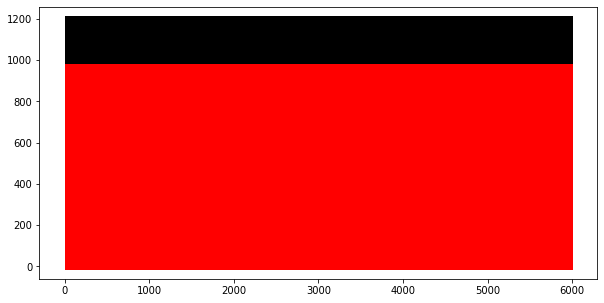

In [3]:
# spike trains
plt.figure(figsize=(10, 5))
plot(sp_mon_exc.t/second, sp_mon_exc.i, '|r')
plot(sp_mon_inh.t/second, sp_mon_inh.i + N_exc, '|k')
plt.show()

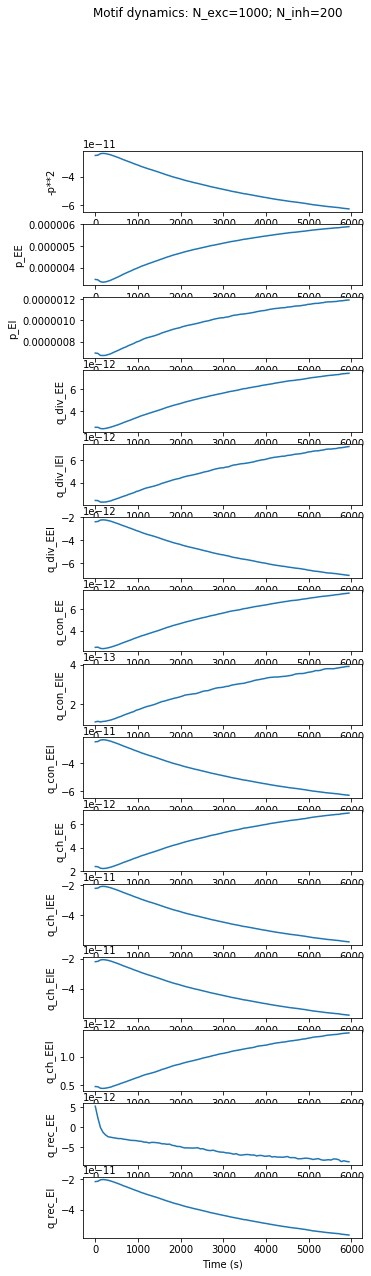

In [4]:
# individual IEI motifs
plot_all_motif_dynamics2(w_mon_exc, w_mon_inh, synapses_exc, synapses_inh, N_exc, N_inh, use_p0=False)

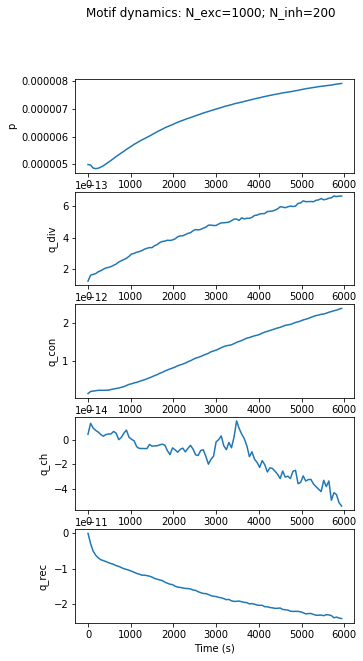

In [5]:
# figure 7
plot_motif_dynamics2(w_mon_exc, w_mon_inh, synapses_exc, synapses_inh, N_exc, N_inh, use_p0=False)

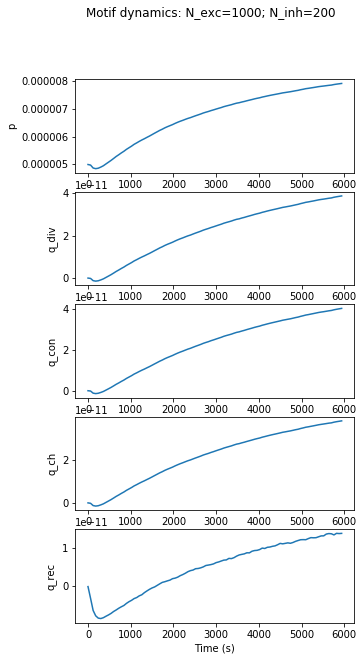

In [6]:
# figure 7
plot_motif_dynamics2(w_mon_exc, w_mon_inh, synapses_exc, synapses_inh, N_exc, N_inh, use_p0=True)

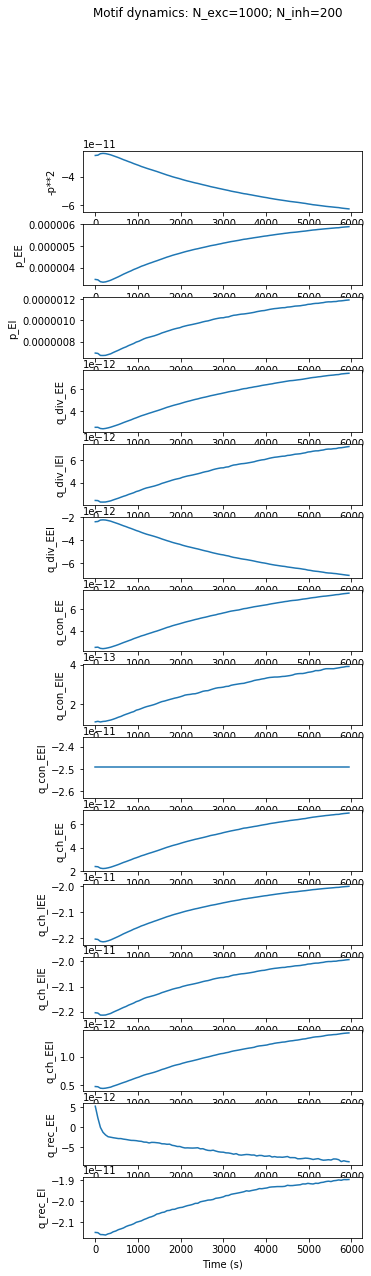

In [7]:
# figure 7
plot_all_motif_dynamics2(w_mon_exc, w_mon_inh, synapses_exc, synapses_inh, N_exc, N_inh, use_p0=True)